### General advice (delete this cell before submitting for review)

> * When choosing a location for your analysis, **select an area that has data on both the NCI and DEA Sandbox** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products).
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
> * When adding **Products used**, embed the hyperlink to that specific product on the DEA Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * Use Australian English in markdown cells and code comments.
> * Check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DEA docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in heirachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * For additional guidance, refer to the style conventions and layouts in approved `develop` branch notebooks. 
Examples include
    * [Frequently_used_code/Using_load_ard.ipynb](./Frequently_used_code/Using_load_ard.ipynb)
    * [Real_world_examples/Coastal_erosion.ipynb](./Real_world_examples/Coastal_erosion.ipynb)
    * [Scripts/dea_datahandling.py](./Scripts/dea_datahandling.py)
> * The DEA Image placed in the title cell will display as long as the notebook is contained in one of the standard directories.
It does not work in the highest level directory (hence why it doesn't display in the original template notebook).
> * In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case (unless the tag is an acronym), separate words with spaces (unless it is the name of an imported module), and [re-use existing tags](https://github.com/GeoscienceAustralia/dea-notebooks/wiki/List-of-tags).
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


# Chessboard segmentation of imagery <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we load some landsat data for a chosen time frame
2. Then we extract each Landsat raster pixel as a polygon vector
3. Then we export our chessboard segmented polygon
4. Then we pull back the tci values for each pixel 
5. then we export those as well
6. Then we do the same for s2 imagery
7. then I tidy this notebook up

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import xarray as xr

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../Scripts'))
from dea_datahandling import load_ard

sys.path.append('../Scripts')
from dea_plotting import rgb


#chessboard notebook
%matplotlib inline
from datacube.helpers import write_geotiff
from datacube.storage import masking
#from datacube.utils.geometry import CRS, point, masking
from datacube import Datacube
from datetime import datetime
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape

import dask

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = Datacube(app='Chessboard segment+ TCI and WOfS')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


## Analysis parameters

* `time_of_interest` : Enter a time, in units YYYY-MM-DD, around which to load satellite data e.g. `'2019-01-01'`
* `time_buff` : A buffer of a given duration (e.g. days) around the time_of_interest parameter, e.g. `'30 days'`
* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON)
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. Each row of this column should have a unique identifier
* `products` : A list of product names to load from the datacube e.g. `['ga_ls7e_ard_3', 'ga_ls8c_ard_3']`
* `measurements` : A list of band names to load from the satellite product e.g. `['nbart_red', 'nbart_green']`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Landsat, this is `(-30, 30)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `align` : How to align the x, y coordinates respect to each pixel e.g. Landsat Collection 3 should be centre aligned `(15, 15)` 

In [3]:
products = ['ga_ls8c_ard_3'] #include all landsat here, as this is a demo notebook but we want to make it reusable for any time period ideally
measurements =['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir','nbart_swir_1','nbart_swir_2']
resolution = (-30, 30)
output_crs = 'EPSG:3577'
align = (15, 15)

# vector_file = '../Supplementary_data/Analyse_multiple_polygons/multiple_polys.shp'
# attribute_col = 'id'

## Set up a query for our area of interest
Grab landsat satellite data first

In [4]:
# Create a landsat query
ls_query = {
    'x': (153.39, 153.58),
    'y': (-27.38, -27.74),
    'time': ('2018-08-01', '2018-10-01'),
    'measurements': ['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir','nbart_swir_1','nbart_swir_2'],
    'output_crs': output_crs,
    'align': align,
    'resolution': resolution,
    'group_by': 'solar_day'
}

In [5]:
# Load available data from Landsat satellites
    # Load landsat
    ds = load_ard(dc=dc, 
                  products=products,
                  min_gooddata=0.99,  # only take uncloudy scenes
                  ls7_slc_off = False,                 
                  **ls_query)

Loading ga_ls8c_ard_3 data
    Filtering to 1 out of 3 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 1 observations 


### Plot up some data to take a look at it

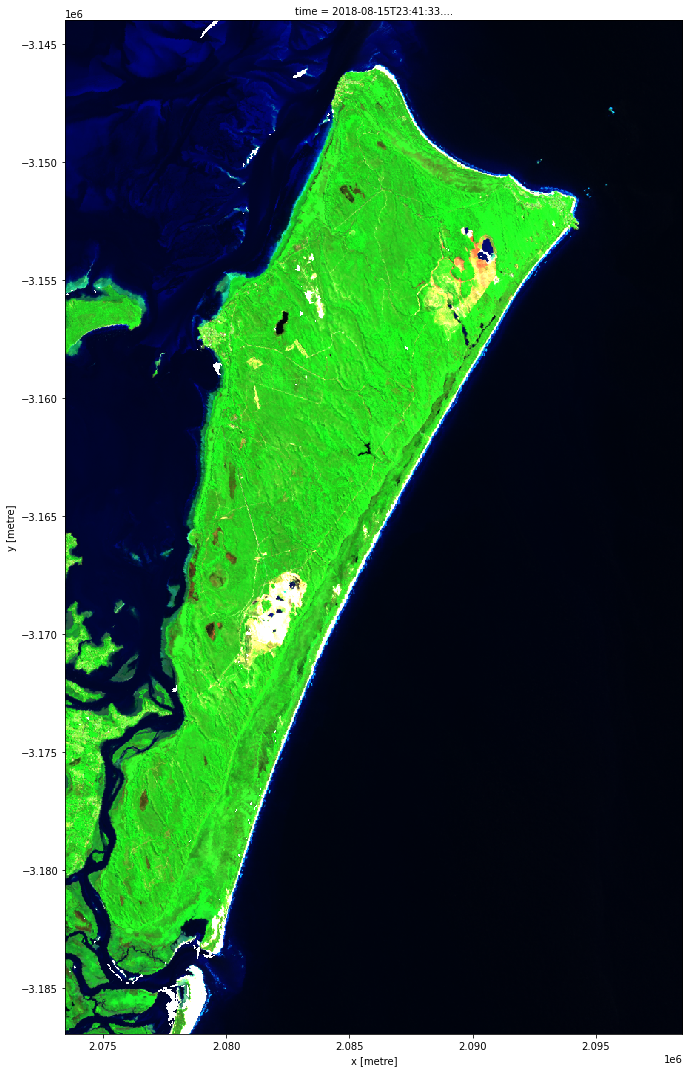

In [6]:
rgb(ds, bands = ['nbart_swir_2','nbart_nir','nbart_green'],size =15, col='time')

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [7]:
ds

<xarray.Dataset>
Dimensions:       (time: 1, x: 835, y: 1432)
Coordinates:
    spatial_ref   int32 0
  * x             (x) float64 2.073e+06 2.074e+06 ... 2.098e+06 2.098e+06
  * y             (y) float64 -3.144e+06 -3.144e+06 ... -3.187e+06 -3.187e+06
  * time          (time) datetime64[ns] 2018-08-15T23:41:33.597882
Data variables:
    nbart_blue    (time, y, x) float32 497.0 496.0 495.0 ... 230.0 229.0 223.0
    nbart_green   (time, y, x) float32 431.0 432.0 430.0 ... 157.0 162.0 153.0
    nbart_red     (time, y, x) float32 155.0 157.0 155.0 ... 93.0 94.0 86.0
    nbart_nir     (time, y, x) float32 51.0 54.0 59.0 57.0 ... 53.0 50.0 51.0
    nbart_swir_1  (time, y, x) float32 26.0 23.0 21.0 19.0 ... 28.0 26.0 24.0
    nbart_swir_2  (time, y, x) float32 17.0 13.0 19.0 19.0 ... 21.0 26.0 17.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [8]:
# Input array to segment and vectorise
input_array = ds.nbart_red[0]
input_transform = ds.affine #(30, 0, 0, 0, -30, 0)  # replace with xarray transform

In [9]:
ds.affine

Affine(30.0, 0.0, 2073465.0,
       0.0, -30.0, -3143985.0)

In [10]:
input_crs = ds.crs

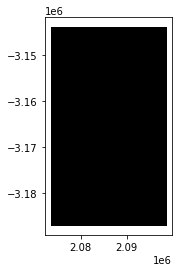

In [11]:
# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)

# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)

# Extract polygons and values from generator
vectors = list(vectors)
values = [value for polygon, value in vectors]
polygons = [shape(polygon) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'id': values},
                       geometry=polygons,
                       crs=input_crs)

# Plot vectors by attribute
gdf.plot(column='id', edgecolor='black')

In [12]:
gdf

,id,geometry
0,0.0,"POLYGON ((2073465.000 -3143985.000, 2073465.00..."
1,1.0,"POLYGON ((2073495.000 -3143985.000, 2073495.00..."
2,2.0,"POLYGON ((2073525.000 -3143985.000, 2073525.00..."
3,3.0,"POLYGON ((2073555.000 -3143985.000, 2073555.00..."
4,4.0,"POLYGON ((2073585.000 -3143985.000, 2073585.00..."
...,...,...
1195715,16067.0,"POLYGON ((2098365.000 -3186915.000, 2098365.00..."
1195716,16068.0,"POLYGON ((2098395.000 -3186915.000, 2098395.00..."
1195717,16069.0,"POLYGON ((2098425.000 -3186915.000, 2098425.00..."
1195718,16070.0,"POLYGON ((2098455.000 -3186915.000, 2098455.00..."


In [13]:
gdf.to_file('TEST2.geojson', driver='GeoJSON')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)